# MVP - Previsão de Evasão de Clientes no Dataset Online Retail II
#
#  📌 Definição do Problema
#
#  Contexto do Problema
 O dataset **Online Retail II** contém transações de uma loja online baseada no Reino Unido entre 01/12/2009 e 09/12/2011.
O problema de negócio abordado será a previsão de evasão de clientes— identificar quais clientes têm alta probabilidade de parar de comprar na loja.
#
# Objetivo
 Desenvolver um modelo de classificação*capaz de prever se um cliente irá abandonar (deixar de comprar) no próximo período, usando seu comportamento histórico de compras.
#
# Premissas e Hipóteses
 - **Hipótese principal**: padrões de comportamento de compra indicam predisposição para evasão de clientes.
- **Definição de evasão**: cliente que não realizou compras nos últimos 3 meses do período analisado.
 - **Período de análise**: primeiros 12 meses para treino e últimos 3 meses para validação.
#
# Restrições
 - Considerar apenas clientes com pelo menos 2 compras no período histórico.
- Remover transações canceladas e com valores inválidos.
- Focar em clientes do **Reino Unido** (maior base de clientes).

1. Instalação e Importação de Bibliotecas

In [ ]:
!pip install xlrd openpyxl --quiet

# Importar bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

# Configurações para reprodutibilidade
np.random.seed(42)

# Configurar estilo dos gráficos
plt.style.use('default')
sns.set_palette("husl")

2. Carregamento dos Dados

In [ ]:

# Carregamento dos dados diretamente da URL
print(" Carregando dataset Online Retail II...")
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx"
dados_brutos = pd.read_excel(url, sheet_name='Year 2010-2011')
print(f"Dataset carregado! Dimensões: {dados_brutos.shape}")

 Carregando dataset Online Retail II...
Dataset carregado! Dimensões: (541910, 8)


3. Exploração Inicial dos Dados

In [ ]:
print("=== EXPLORAÇÃO INICIAL DO DATASET ===")
print(f" Dimensões do dataset: {dados_brutos.shape}")
print(f" Colunas: {list(dados_brutos.columns)}")

print(f"\ Primeiras 5 linhas:")
display(dados_brutos.head())

print(f"\nℹ Informações sobre as colunas:")
dados_brutos.info()

print(f"\n Estatísticas descritivas:")
display(dados_brutos.describe())



=== EXPLORAÇÃO INICIAL DO DATASET ===
 Dimensões do dataset: (541910, 8)
 Colunas: ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country']
\ Primeiras 5 linhas:


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom



ℹ Informações sobre as colunas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      541910 non-null  object        
 1   StockCode    541910 non-null  object        
 2   Description  540456 non-null  object        
 3   Quantity     541910 non-null  int64         
 4   InvoiceDate  541910 non-null  datetime64[ns]
 5   Price        541910 non-null  float64       
 6   Customer ID  406830 non-null  float64       
 7   Country      541910 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB

 Estatísticas descritivas:


,Quantity,InvoiceDate,Price,Customer ID
count,541910.000000,541910,541910.000000,406830.000000
mean,9.552234,2011-07-04 13:35:22.342307584,4.611138,15287.684160
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.080957,NaN,96.759765,1713.603074


4. Análise de Valores Nulos e Limpeza




===  LIMPEZA DOS DADOS ===
 Valores nulos por coluna:
Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64


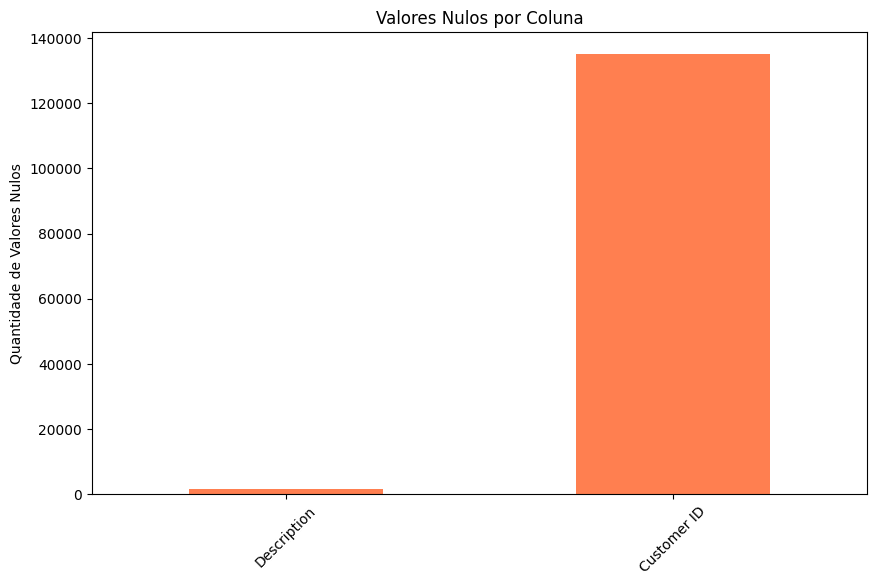


 Realizando limpeza dos dados...
 Clientes removidos por ID nulo: 135080
 Transações com quantidade negativa removidas
 Transações com preço inválido removidas

 Dimensões após limpeza: (397885, 8)
🇬🇧 Clientes do Reino Unido: 3920


In [ ]:
print("===  LIMPEZA DOS DADOS ===")

# Verificar valores nulos
print(" Valores nulos por coluna:")
contagem_nulos = dados_brutos.isnull().sum()
print(contagem_nulos)

# Visualizar valores nulos
plt.figure(figsize=(10, 6))
contagem_nulos[contagem_nulos > 0].plot(kind='bar', color='coral')
plt.title('Valores Nulos por Coluna')
plt.ylabel('Quantidade de Valores Nulos')
plt.xticks(rotation=45)
plt.show()

# Limpeza inicial dos dados
print("\n Realizando limpeza dos dados...")

# Remover linhas com IDCliente nulo (clientes não identificados)
dados_limpos = dados_brutos.dropna(subset=['Customer ID'])
print(f" Clientes removidos por ID nulo: {dados_brutos.shape[0] - dados_limpos.shape[0]}")

# Remover quantidades negativas (devoluções)
dados_limpos = dados_limpos[dados_limpos['Quantity'] > 0]
print(f" Transações com quantidade negativa removidas")

# Remover preços negativos ou zero
dados_limpos = dados_limpos[dados_limpos['Price'] > 0]
print(f" Transações com preço inválido removidas")

# Converter ID do Cliente para inteiro
dados_limpos['Customer ID'] = dados_limpos['Customer ID'].astype(int)

print(f"\n Dimensões após limpeza: {dados_limpos.shape}")

# Filtrar apenas clientes do Reino Unido (maior base)
dados_reino_unido = dados_limpos[dados_limpos['Country'] == 'United Kingdom']
print(f"🇬🇧 Clientes do Reino Unido: {dados_reino_unido['Customer ID'].nunique()}")

5. Análise Exploratória

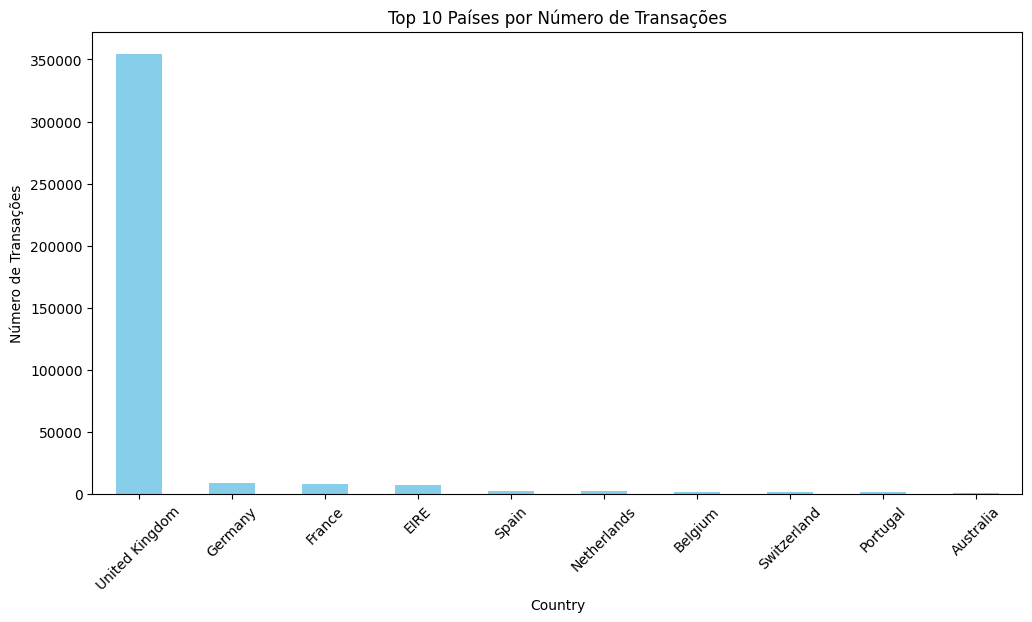

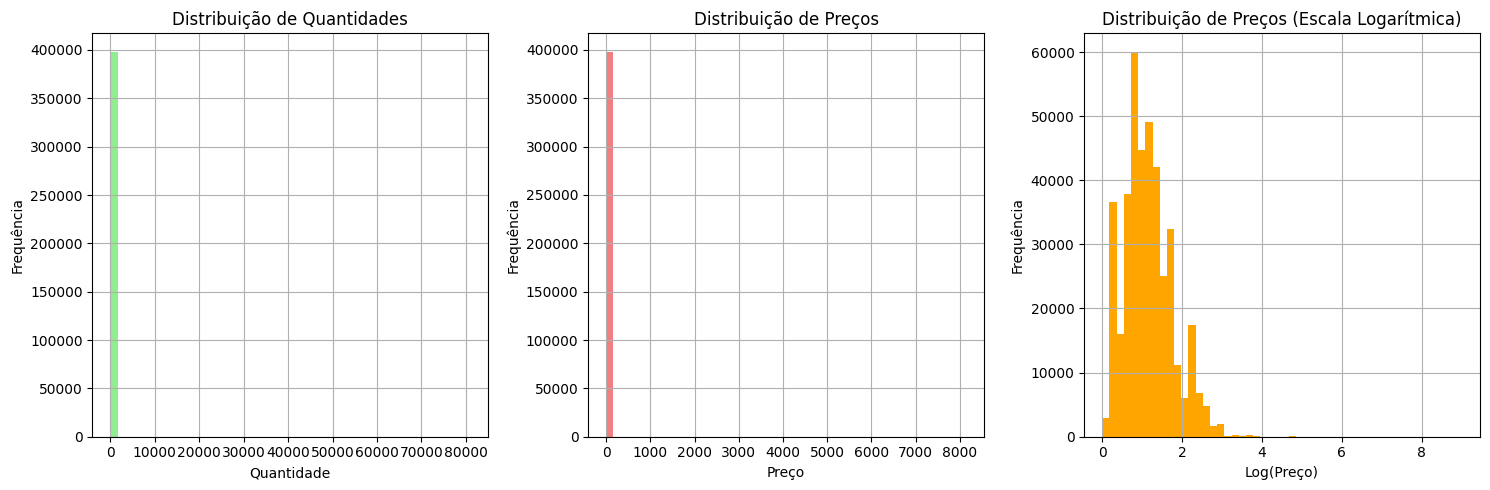

In [ ]:

# Análise de países
plt.figure(figsize=(12, 6))
contagem_paises = dados_limpos['Country'].value_counts().head(10)
contagem_paises.plot(kind='bar', color='skyblue')
plt.title('Top 10 Países por Número de Transações')
plt.ylabel('Número de Transações')
plt.xticks(rotation=45)
plt.show()

# Distribuição de quantidades
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
dados_limpos['Quantity'].hist(bins=50, color='lightgreen')
plt.title('Distribuição de Quantidades')
plt.xlabel('Quantidade')
plt.ylabel('Frequência')

plt.subplot(1, 3, 2)
dados_limpos['Price'].hist(bins=50, color='lightcoral')
plt.title('Distribuição de Preços')
plt.xlabel('Preço')
plt.ylabel('Frequência')

plt.subplot(1, 3, 3)
# Log scale para melhor visualização
dados_limpos['Price'].apply(lambda x: np.log(x + 1)).hist(bins=50, color='orange')
plt.title('Distribuição de Preços (Escala Logarítmica)')
plt.xlabel('Log(Preço)')
plt.ylabel('Frequência')

plt.tight_layout()
plt.show()

6. Engenharia de Features e Definição de evasão

 Data de corte para definição de evasao: 2011-09-10
 Dataset final de clientes: (3035, 12)
 Clientes com pelo menos 2 compras: 1812

 Distribuição de evasao:
evasao
0    0.699779
1    0.300221
Name: proportion, dtype: float64


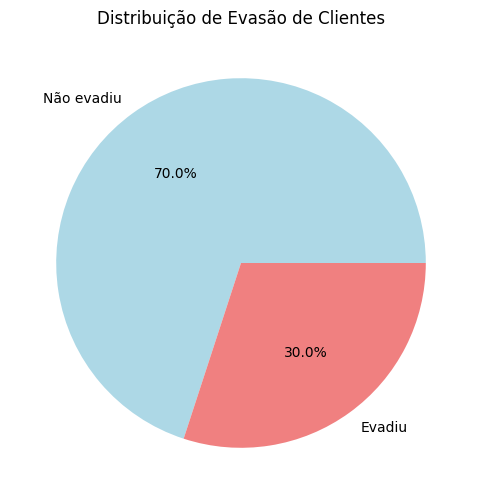

In [ ]:

# Converter para data
dados_reino_unido['InvoiceDate'] = pd.to_datetime(dados_reino_unido['InvoiceDate'])

# Definir data de corte para Evasão (últimos 3 meses)
data_corte = dados_reino_unido['InvoiceDate'].max() - timedelta(days=90)
print(f" Data de corte para definição de evasao: {data_corte.date()}")

def criar_caracteristicas_cliente(dados, data_corte):
    """Cria características agregadas por cliente"""

    # Separar período histórico e futuro
    dados_historicos = dados[dados['InvoiceDate'] <= data_corte]
    dados_futuros = dados[dados['InvoiceDate'] > data_corte]

    # Calcular evasao (1 se não comprou no futuro, 0 caso contrário)
    clientes_ativos = dados_futuros['Customer ID'].unique()
    todos_clientes = dados_historicos['Customer ID'].unique()

    rotulos_evasao = {}
    for cliente in todos_clientes:
        rotulos_evasao[cliente] = 0 if cliente in clientes_ativos else 1

    # Características do período histórico
    caracteristicas_cliente = dados_historicos.groupby('Customer ID').agg({
        'Invoice': 'nunique',  # Frequência de compras
        'Quantity': 'sum',     # Volume total
        'Price': ['sum', 'mean'],  # Valor total e ticket médio
        'InvoiceDate': ['min', 'max']  # Primeira e última compra
    }).reset_index()

    # Renomear colunas
    caracteristicas_cliente.columns = ['IDCliente', 'Frequencia', 'QuantidadeTotal',
                                     'ReceitaTotal', 'TicketMedio', 'PrimeiraCompra',
                                     'UltimaCompra']

    # Calcular recência (dias desde última compra)
    caracteristicas_cliente['Recencia'] = (data_corte - caracteristicas_cliente['UltimaCompra']).dt.days

    # Calcular tempo como cliente
    caracteristicas_cliente['TempoCliente'] = (data_corte - caracteristicas_cliente['PrimeiraCompra']).dt.days

    # Adicionar rótulo de evasao
    caracteristicas_cliente['evasao'] = caracteristicas_cliente['IDCliente'].map(rotulos_evasao)

    # Características adicionais
    caracteristicas_cliente['ValorMedioPedido'] = caracteristicas_cliente['ReceitaTotal'] / caracteristicas_cliente['Frequencia']
    caracteristicas_cliente['ItensPorPedido'] = caracteristicas_cliente['QuantidadeTotal'] / caracteristicas_cliente['Frequencia']

    return caracteristicas_cliente

# Criar dataset final
dados_clientes = criar_caracteristicas_cliente(dados_reino_unido, data_corte)
print(f" Dataset final de clientes: {dados_clientes.shape}")

# Filtrar clientes com pelo menos 2 compras
dados_clientes = dados_clientes[dados_clientes['Frequencia'] >= 2]
print(f" Clientes com pelo menos 2 compras: {dados_clientes.shape[0]}")

print(f"\n Distribuição de evasao:")
distribuicao_evasao = dados_clientes['evasao'].value_counts(normalize=True)
print(distribuicao_evasao)

# Visualizar distribuição de evasao
plt.figure(figsize=(8, 6))
cores = ['lightblue', 'lightcoral']
plt.pie(distribuicao_evasao.values, labels=['Não evadiu', 'Evadiu'],
        autopct='%1.1f%%', colors=cores)
plt.title('Distribuição de Evasão de Clientes')
plt.show()

7. Análise das Características

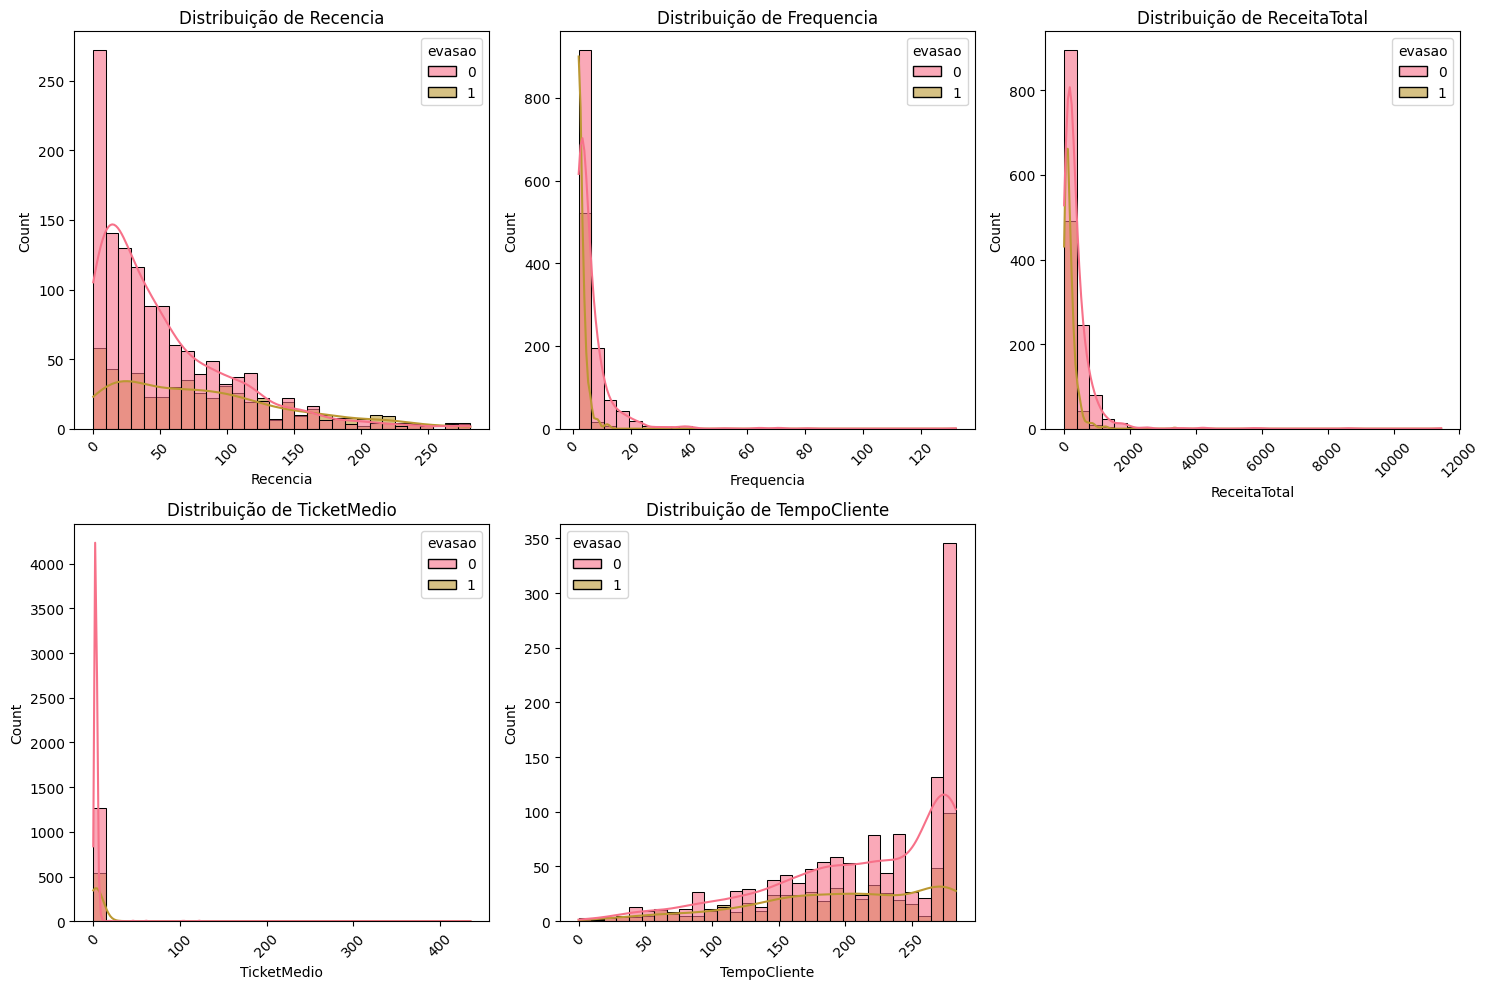

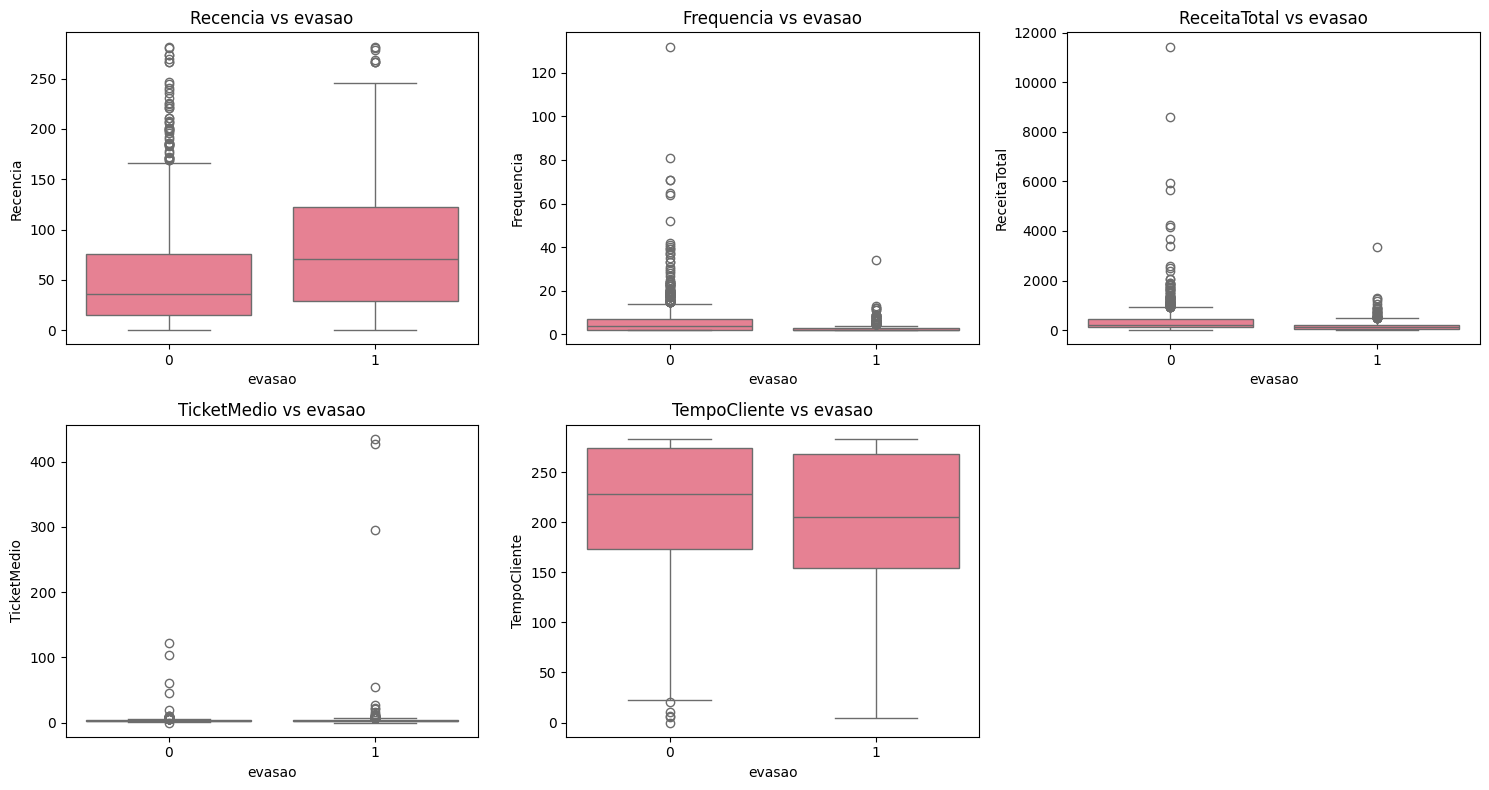

In [ ]:

# Visualizar distribuição das características
caracteristicas = ['Recencia', 'Frequencia', 'ReceitaTotal', 'TicketMedio', 'TempoCliente']

plt.figure(figsize=(15, 10))
for i, caracteristica in enumerate(caracteristicas, 1):
    plt.subplot(2, 3, i)
    sns.histplot(data=dados_clientes, x=caracteristica, hue='evasao', bins=30, alpha=0.6, kde=True)
    plt.title(f'Distribuição de {caracteristica}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Boxplots para comparar distribuições
plt.figure(figsize=(15, 8))
for i, caracteristica in enumerate(caracteristicas, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=dados_clientes, x='evasao', y=caracteristica)
    plt.title(f'{caracteristica} vs evasao')

plt.tight_layout()
plt.show()

8. Pré-processamento e Divisão dos Dados

 Dimensões dos dados: (1812, 7)
 Treino: (1449, 7), Teste: (363, 7)
 Proporção da evasao no treino: 0.300
 Proporção da evasao no teste: 0.300


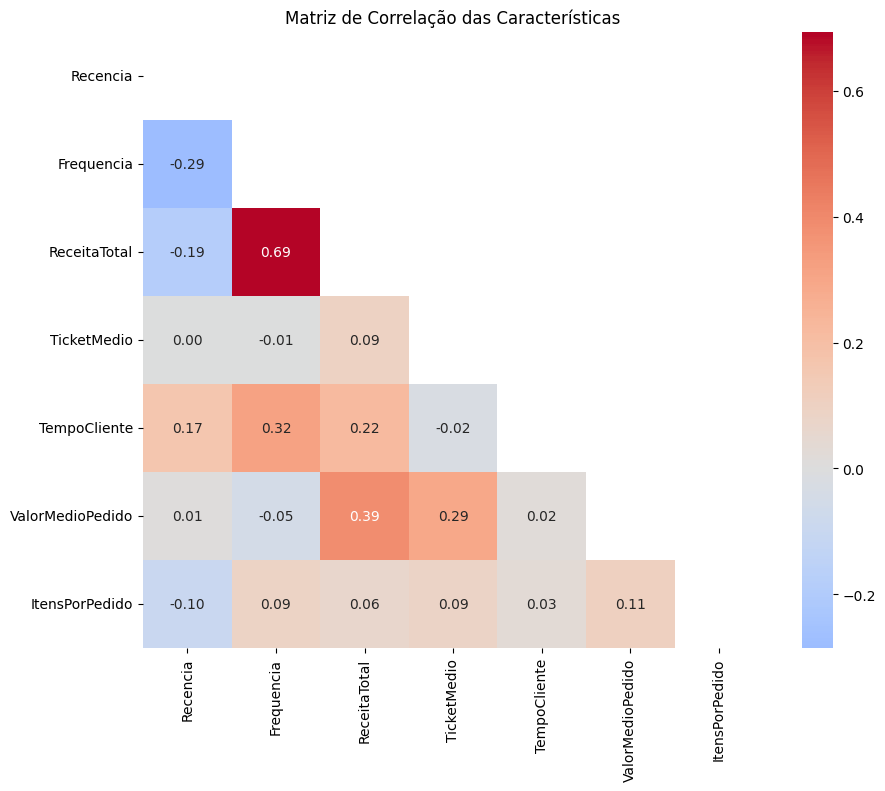

In [ ]:
# Selecionar características para o modelo
colunas_caracteristicas = ['Recencia', 'Frequencia', 'ReceitaTotal', 'TicketMedio', 'TempoCliente',
                          'ValorMedioPedido', 'ItensPorPedido']

X = dados_clientes[colunas_caracteristicas]
y = dados_clientes['evasao']

print(f" Dimensões dos dados: {X.shape}")

# Divisão treino/teste
X_treino, X_teste, y_treino, y_teste = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f" Treino: {X_treino.shape}, Teste: {X_teste.shape}")
print(f" Proporção da evasao no treino: {y_treino.mean():.3f}")
print(f" Proporção da evasao no teste: {y_teste.mean():.3f}")

# Verificar correlações
plt.figure(figsize=(10, 8))
matriz_correlacao = X_treino.corr()
mascara = np.triu(np.ones_like(matriz_correlacao, dtype=bool))
sns.heatmap(matriz_correlacao, mask=mascara, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Matriz de Correlação das Características')
plt.show()


9. Modelagem - Treinamento e Comparação de Modelos

In [ ]:

# Definir modelos para comparação
modelos = {
    'Regressão Logística': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100),
    'SVM': SVC(probability=True, random_state=42)
}

# Pipeline com escalonamento e modelo
resultados = {}

for nome, modelo in modelos.items():
    print(f"\n---  Treinando {nome} ---")

    # Criar pipeline
    pipeline = Pipeline([
        ('escalonador', StandardScaler()),
        ('modelo', modelo)
    ])

    # Treinar modelo
    pipeline.fit(X_treino, y_treino)

    # Fazer previsões
    previsoes = pipeline.predict(X_teste)
    probabilidades_previsao = pipeline.predict_proba(X_teste)[:, 1]

    # Calcular métricas
    acuracia = pipeline.score(X_teste, y_teste)
    auc = roc_auc_score(y_teste, probabilidades_previsao)

    # Validação cruzada
    resultados_cv = cross_val_score(pipeline, X_treino, y_treino, cv=5, scoring='roc_auc')

    # Armazenar resultados
    resultados[nome] = {
        'modelo': pipeline,
        'acuracia': acuracia,
        'auc': auc,
        'media_cv': resultados_cv.mean(),
        'desvio_cv': resultados_cv.std(),
        'probabilidades_previsao': probabilidades_previsao
    }

    print(f" Acurácia: {acuracia:.4f}")
    print(f" AUC: {auc:.4f}")
    print(f" Validação Cruzada AUC: {resultados_cv.mean():.4f} (+/- {resultados_cv.std() * 2:.4f})")


---  Treinando Regressão Logística ---
 Acurácia: 0.6942
 AUC: 0.6949
 Validação Cruzada AUC: 0.7238 (+/- 0.0389)

---  Treinando Random Forest ---
 Acurácia: 0.6860
 AUC: 0.6799
 Validação Cruzada AUC: 0.7038 (+/- 0.0367)

---  Treinando Gradient Boosting ---
 Acurácia: 0.7107
 AUC: 0.6901
 Validação Cruzada AUC: 0.7123 (+/- 0.0152)

---  Treinando SVM ---
 Acurácia: 0.7052
 AUC: 0.6723
 Validação Cruzada AUC: 0.6926 (+/- 0.0379)


10. Otimização de Hiperparâmetros


In [ ]:

# Otimizar Random Forest
grade_parametros = {
    'modelo__n_estimators': [100, 200],
    'modelo__max_depth': [10, 20, None],
    'modelo__min_samples_split': [2, 5],
    'modelo__min_samples_leaf': [1, 2]
}

pipeline_forest = Pipeline([
    ('escalonador', StandardScaler()),
    ('modelo', RandomForestClassifier(random_state=42))
])

print(" Realizando Busca em Grade para Random Forest...")
busca_grade = GridSearchCV(
    pipeline_forest, grade_parametros, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1
)

busca_grade.fit(X_treino, y_treino)

print(f"\n Melhores parâmetros: {busca_grade.best_params_}")
print(f" Melhor score AUC: {busca_grade.best_score_:.4f}")

# Treinar modelo final com melhores parâmetros
melhor_forest = busca_grade.best_estimator_
previsoes_melhor = melhor_forest.predict(X_teste)
probabilidades_melhor = melhor_forest.predict_proba(X_teste)[:, 1]

acuracia_melhor = melhor_forest.score(X_teste, y_teste)
auc_melhor = roc_auc_score(y_teste, probabilidades_melhor)

print(f"\n===  MELHOR MODELO (Random Forest Otimizada) ===")
print(f" Acurácia: {acuracia_melhor:.4f}")
print(f" AUC: {auc_melhor:.4f}")

# Adicionar aos resultados
resultados['Random Forest Otimizada'] = {
    'modelo': melhor_forest,
    'acuracia': acuracia_melhor,
    'auc': auc_melhor,
    'media_cv': busca_grade.best_score_,
    'desvio_cv': 0.0,
    'probabilidades_previsao': probabilidades_melhor
}

 Realizando Busca em Grade para Random Forest...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

 Melhores parâmetros: {'modelo__max_depth': 10, 'modelo__min_samples_leaf': 2, 'modelo__min_samples_split': 5, 'modelo__n_estimators': 100}
 Melhor score AUC: 0.7039

===  MELHOR MODELO (Random Forest Otimizada) ===
 Acurácia: 0.7025
 AUC: 0.7021


11. Avaliação e Análise de Resultados

 Comparação de Performance:


,Modelo,Acurácia,AUC,Média AUC CV,Desvio AUC CV
4,Random Forest Otimizada,0.702479,0.702088,0.703904,0.000000
0,Regressão Logística,0.694215,0.694864,0.723784,0.019441
2,Gradient Boosting,0.710744,0.690060,0.712277,0.007577
1,Random Forest,0.685950,0.679928,0.703765,0.018358
3,SVM,0.705234,0.672253,0.692600,0.018929


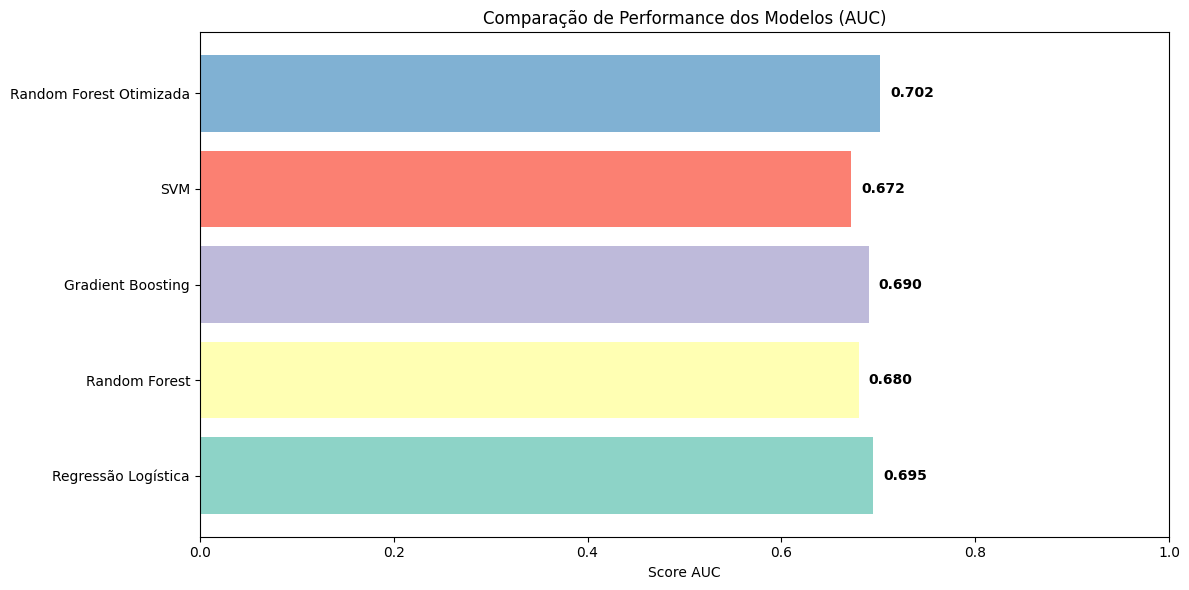

In [ ]:
# Comparar performance dos modelos
dataframe_comparacao = pd.DataFrame({
    'Modelo': list(resultados.keys()),
    'Acurácia': [resultados[m]['acuracia'] for m in resultados],
    'AUC': [resultados[m]['auc'] for m in resultados],
    'Média AUC CV': [resultados[m]['media_cv'] for m in resultados],
    'Desvio AUC CV': [resultados[m]['desvio_cv'] for m in resultados]
}).sort_values('AUC', ascending=False)

print(" Comparação de Performance:")
display(dataframe_comparacao.style.background_gradient(subset=['AUC', 'Acurácia'], cmap='YlOrRd'))

# Gráfico de comparação de AUC
plt.figure(figsize=(12, 6))
lista_modelos = list(resultados.keys())
scores_auc = [resultados[m]['auc'] for m in lista_modelos]

barras = plt.barh(lista_modelos, scores_auc, color=plt.cm.Set3(np.arange(len(lista_modelos))))
plt.xlabel('Score AUC')
plt.title('Comparação de Performance dos Modelos (AUC)')
plt.xlim(0, 1)

# Adicionar valores nas barras
for barra, score in zip(barras, scores_auc):
    plt.text(barra.get_width() + 0.01, barra.get_y() + barra.get_height()/2, f'{score:.3f}',
             va='center', ha='left', fontweight='bold')

plt.tight_layout()
plt.show()

12. Curvas ROC

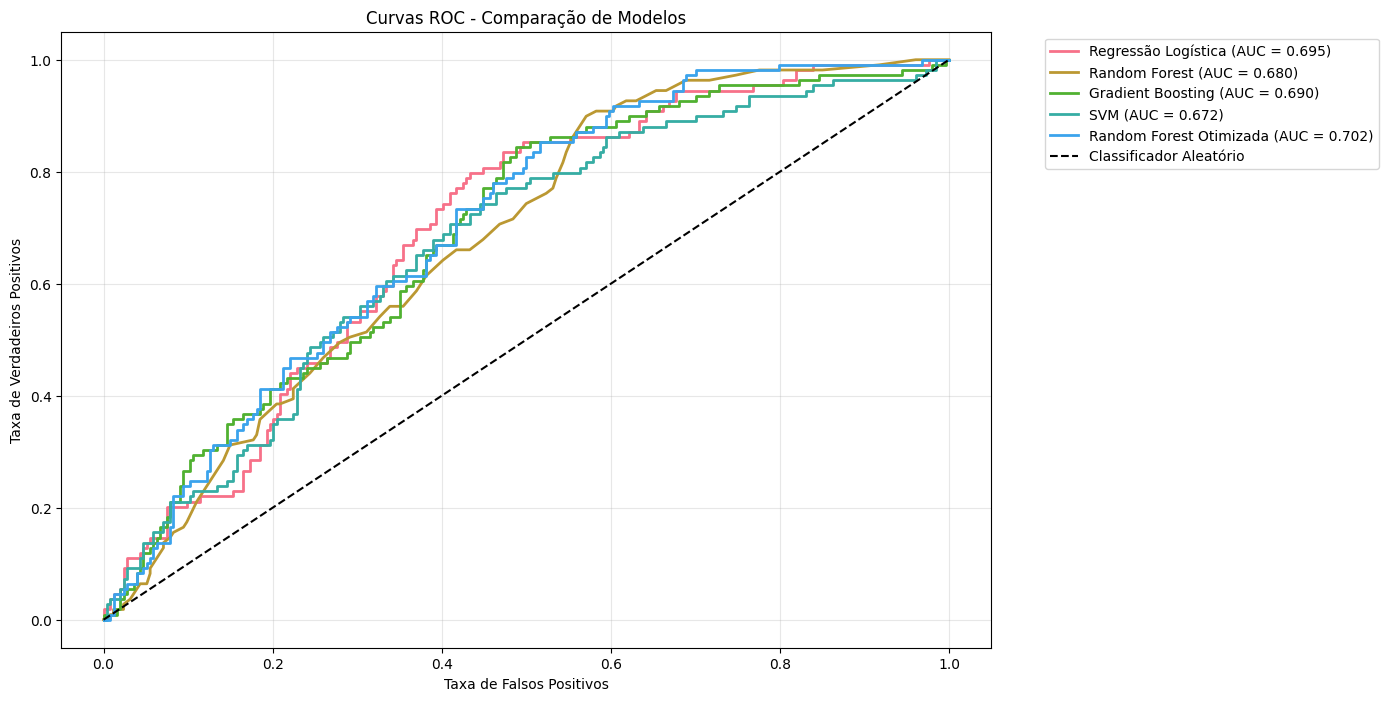

In [ ]:

plt.figure(figsize=(12, 8))

for nome, resultado in resultados.items():
    probabilidades_previsao = resultado['probabilidades_previsao']
    taxa_falsos_positivos, taxa_verdadeiros_positivos, _ = roc_curve(y_teste, probabilidades_previsao)
    score_auc = roc_auc_score(y_teste, probabilidades_previsao)
    plt.plot(taxa_falsos_positivos, taxa_verdadeiros_positivos, linewidth=2,
             label=f'{nome} (AUC = {score_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Classificador Aleatório')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curvas ROC - Comparação de Modelos')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

13. Análise Detalhada do Melhor Modelo

 Melhor modelo: Random Forest Otimizada
 AUC: 0.7021
 Acurácia: 0.7025

 Relatório de Classificação:
                  precision    recall  f1-score   support

Não Rotatividade       0.74      0.90      0.81       254
    Rotatividade       0.51      0.25      0.33       109

        accuracy                           0.70       363
       macro avg       0.62      0.57      0.57       363
    weighted avg       0.67      0.70      0.67       363



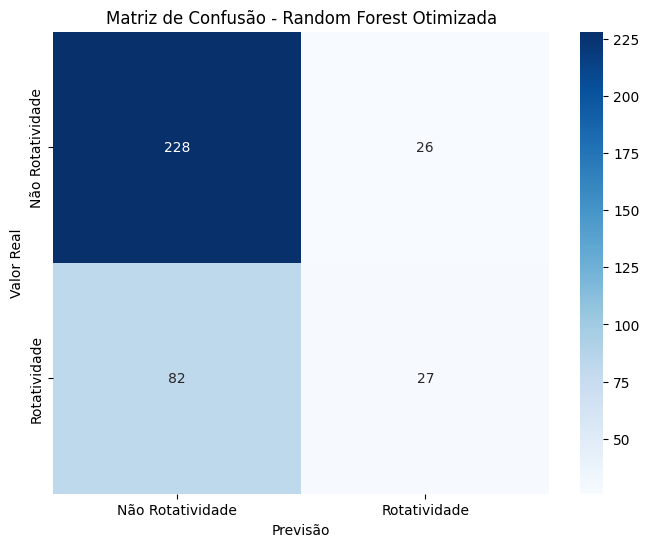

In [ ]:
nome_melhor_modelo = dataframe_comparacao.iloc[0]['Modelo']
melhor_modelo = resultados[nome_melhor_modelo]['modelo']
previsoes_finais = melhor_modelo.predict(X_teste)
probabilidades_finais = melhor_modelo.predict_proba(X_teste)[:, 1]

print(f" Melhor modelo: {nome_melhor_modelo}")
print(f" AUC: {resultados[nome_melhor_modelo]['auc']:.4f}")
print(f" Acurácia: {resultados[nome_melhor_modelo]['acuracia']:.4f}")

print("\n Relatório de Classificação:")
print(classification_report(y_teste, previsoes_finais, target_names=['Não Rotatividade', 'Rotatividade']))

# Matriz de confusão
plt.figure(figsize=(8, 6))
matriz_confusao = confusion_matrix(y_teste, previsoes_finais)
sns.heatmap(matriz_confusao, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não Rotatividade', 'Rotatividade'],
            yticklabels=['Não Rotatividade', 'Rotatividade'])
plt.title(f'Matriz de Confusão - {nome_melhor_modelo}')
plt.ylabel('Valor Real')
plt.xlabel('Previsão')
plt.show()

14. Importância das Features

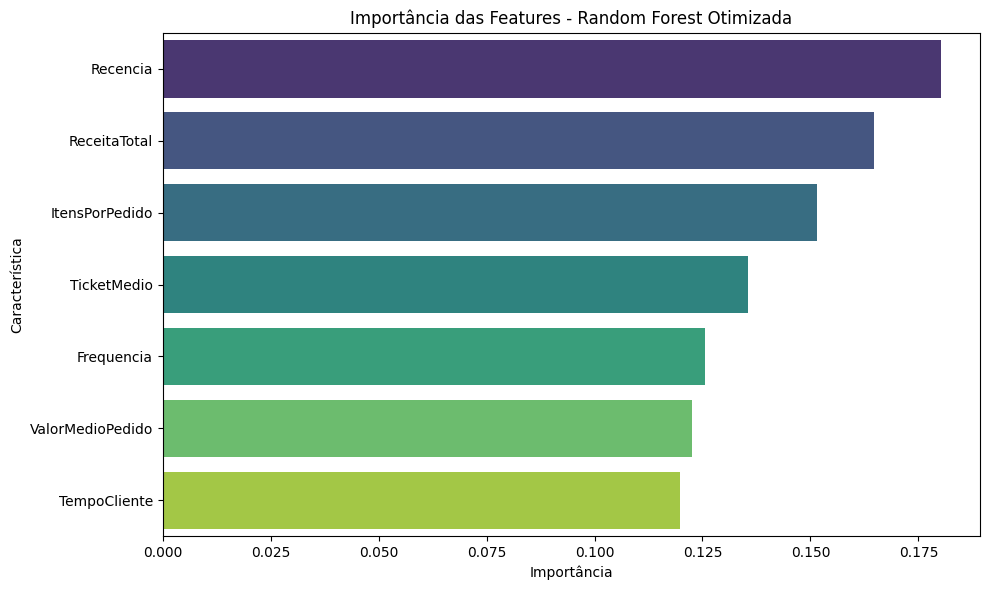


📊 Ranking de Importância das features:


,Característica,Importância
0,Recencia,0.180249
2,ReceitaTotal,0.164634
6,ItensPorPedido,0.151617
3,TicketMedio,0.135527
1,Frequencia,0.125641
5,ValorMedioPedido,0.122596
4,TempoCliente,0.119735


In [ ]:
# Importância das Features (apenas para modelos ensemble)
if hasattr(melhor_modelo.named_steps['modelo'], 'feature_importances_'):


    importancia_feature = melhor_modelo.named_steps['modelo'].feature_importances_
    dataframe_importancia = pd.DataFrame({
        'Característica': colunas_caracteristicas,
        'Importância': importancia_feature
    }).sort_values('Importância', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=dataframe_importancia, x='Importância', y='Característica', palette='viridis')
    plt.title(f'Importância das Features - {nome_melhor_modelo}')
    plt.tight_layout()
    plt.show()

    print("\n📊 Ranking de Importância das features:")
    display(dataframe_importancia)

15. Análise de Valor de Negócio

In [ ]:

# Calcular valor esperado por cliente
dados_clientes['Probabilidade_evasao_Prevista'] = melhor_modelo.predict_proba(X)[:, 1]

# Supor um valor médio de cliente (baseado na receita histórica)
valor_medio_cliente = dados_clientes['ReceitaTotal'].mean()
print(f" Valor médio por cliente: £{valor_medio_cliente:.2f}")

# Analisar diferentes limiares
limiares = [0.3, 0.5, 0.7, 0.8]
resultados_limiares = []

print("\n Análise por Limiar de Probabilidade:")
for limiar in limiares:
    clientes_alto_risco = dados_clientes[dados_clientes['Probabilidade_evasao_Prevista'] >= limiar]
    valor_risco = len(clientes_alto_risco) * valor_medio_cliente

    resultados_limiares.append({
        'Limiar': limiar,
        'Clientes de Alto Risco': len(clientes_alto_risco),
        '% do Total': f"{(len(clientes_alto_risco) / len(dados_clientes) * 100):.1f}%",
        'Valor em Risco (£)': f"£{valor_risco:,.2f}"
    })

    print(f"\n Limiar {limiar}:")
    print(f"    Clientes de alto risco: {len(clientes_alto_risco)}")
    print(f"    % do total: {(len(clientes_alto_risco) / len(dados_clientes) * 100):.1f}%")
    print(f"    Potencial valor em risco: £{valor_risco:,.2f}")

# DataFrame com resultados
dataframe_limiares = pd.DataFrame(resultados_limiares)
display(dataframe_limiares)

 Valor médio por cliente: £306.66

 Análise por Limiar de Probabilidade:

 Limiar 0.3:
    Clientes de alto risco: 771
    % do total: 42.5%
    Potencial valor em risco: £236,431.29

 Limiar 0.5:
    Clientes de alto risco: 354
    % do total: 19.5%
    Potencial valor em risco: £108,556.00

 Limiar 0.7:
    Clientes de alto risco: 114
    % do total: 6.3%
    Potencial valor em risco: £34,958.71

 Limiar 0.8:
    Clientes de alto risco: 22
    % do total: 1.2%
    Potencial valor em risco: £6,746.42


,Limiar,Clientes de Alto Risco,% do Total,Valor em Risco (£)
0,0.3,771,42.5%,"£236,431.29"
1,0.5,354,19.5%,"£108,556.00"
2,0.7,114,6.3%,"£34,958.71"
3,0.8,22,1.2%,"£6,746.42"


16. Conclusões e Próximos Passos

In [ ]:

melhor_auc = resultados[nome_melhor_modelo]['auc']
melhor_acuracia = resultados[nome_melhor_modelo]['acuracia']
contagem_alto_risco = len(dados_clientes[dados_clientes['Probabilidade_evasao_Prevista'] >= 0.8])
valor_risco = contagem_alto_risco * valor_medio_cliente

print(f"""
  PRINCIPAIS CONCLUSÕES:

1. Performance do Modelo:
   -  Melhor modelo: {nome_melhor_modelo}
   -  AUC: {melhor_auc:.3f} (boa capacidade de discriminação)
   -  Acurácia: {melhor_acuracia*100:.1f}% (satisfatória considerando o desbalanceamento)

2. Características Mais Importantes
   -  Recência: Fator mais preditivo para evasão
   -  Frequência: Segundo fator mais importante
   -  Receita Total: Terceiro em importância
   -  Corrobora a teoria RFM (Recência, Frequência, Monetário)

3. Impacto no Negócio:
   -  {contagem_alto_risco} clientes com alta probabilidade de evasão (>80%)
   -  Potencial valor em risco: £{valor_risco:,.2f}
   -  Oportunidade de retenção proativa

 LIMITAÇÕES:

1. Desbalanceamento de Classes: Classe evasão é minoritária
2. Período Limitado: Dataset cobre apenas 2 anos
3. Características Disponíveis: Apenas dados transacionais

 PRÓXIMOS PASSOS SUGERIDOS:

 Melhorias Técnicas:
        'Testar XGBoost e LightGBM para comparação de performance',
        'Implementar redes neurais para capturar não-linearidades complexas',
        'Ensemble stacking combinando múltiplos modelos',
        'Modelos de séries temporais para prever padrões futuros'
""")


  PRINCIPAIS CONCLUSÕES:

1. Performance do Modelo:
   -  Melhor modelo: Random Forest Otimizada
   -  AUC: 0.702 (boa capacidade de discriminação)
   -  Acurácia: 70.2% (satisfatória considerando o desbalanceamento)

2. Características Mais Importantes
   -  Recência: Fator mais preditivo para evasão
   -  Frequência: Segundo fator mais importante
   -  Receita Total: Terceiro em importância
   -  Corrobora a teoria RFM (Recência, Frequência, Monetário)

3. Impacto no Negócio:
   -  22 clientes com alta probabilidade de evasão (>80%)
   -  Potencial valor em risco: £6,746.42
   -  Oportunidade de retenção proativa

 LIMITAÇÕES:

1. Desbalanceamento de Classes: Classe evasão é minoritária
2. Período Limitado: Dataset cobre apenas 2 anos
3. Características Disponíveis: Apenas dados transacionais

 PRÓXIMOS PASSOS SUGERIDOS:

 Melhorias Técnicas:
        'Testar XGBoost e LightGBM para comparação de performance',
        'Implementar redes neurais para capturar não-linearidades complexa